In [128]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
from util import read_json_from, write_json_to
from data import pQTL_protein_df,pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup 
from visualization_util import df_roc_analysis,df_precision_recall_analysis
from validation import validate_relations_in_df,full_report_calculation_by_size,simplifed_report_df,is_corum_verifiable
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pQTL_shared_rna_seq_df = pd.read_csv(f"{PATH_ROOT}/data_sources/pQTL/pQTL_shared_rna_seq.csv")
pQTL_shared_protein_df = pd.read_csv(f"{PATH_ROOT}/data_sources/pQTL/pQTL_shared_protein.csv")

In [137]:
shared_rna_seq_col = [col for col in pQTL_shared_protein_df.columns]
shared_rna_seq_feature_cols = np.array(list(filter(lambda x: 'GM' in x,shared_rna_seq_col)))
shared_rna_seq_first_half_cols = ['ENSG','Uniprot_Id'] + np.split(shared_rna_seq_feature_cols,2)[0].tolist() 
shared_rna_seq_second_half_cols = ['ENSG','Uniprot_Id']  + np.split(shared_rna_seq_feature_cols,2)[1].tolist()
pQTL_shared_rna_seq_df = pQTL_shared_rna_seq_df[shared_rna_seq_col].copy()
pQTL_shared_rna_seq_df_first_half = pQTL_shared_rna_seq_df[shared_rna_seq_first_half_cols]
pQTL_shared_rna_seq_df_first_half_feature_matrix = pQTL_shared_rna_seq_df_first_half.iloc[:,2:].to_numpy()
pQTL_shared_rna_seq_df_second_half = pQTL_shared_rna_seq_df[shared_rna_seq_second_half_cols]
pQTL_shared_rna_seq_df_second_half_feature_matrix = pQTL_shared_rna_seq_df_second_half.iloc[:,2:].to_numpy()

In [153]:
pQTL_shared_rna_seq_df_first_half_gene_variance = np.nanvar(pQTL_shared_rna_seq_df_first_half_feature_matrix, axis=1)
pQTL_shared_rna_seq_df_second_half_gene_variance = np.nanvar(pQTL_shared_rna_seq_df_second_half_feature_matrix, axis=1)
pQTL_shared_rna_seq_df_first_half_cell_variance = np.nanvar(pQTL_shared_rna_seq_df_first_half_feature_matrix, axis=0)
pQTL_shared_rna_seq_df_second_half_cell_variance = np.nanvar(pQTL_shared_rna_seq_df_second_half_feature_matrix, axis=0)
pQTL_shared_rna_seq_reliability_col = pQTL_shared_rna_seq_df_first_half_gene_variance/pQTL_shared_rna_seq_df_second_half_gene_variance

In [191]:
pQTL_shared_rna_seq_gene_reliability = np.corrcoef(pQTL_shared_rna_seq_df_first_half_gene_variance,pQTL_shared_rna_seq_df_second_half_gene_variance)[0,1]
pQTL_shared_rna_seq_cell_reliability = np.corrcoef(pQTL_shared_rna_seq_df_first_half_cell_variance,pQTL_shared_rna_seq_df_second_half_cell_variance)[0,1]
print(pQTL_shared_rna_seq_gene_reliability)
print(pQTL_shared_rna_seq_cell_reliability)
print(sp.stats.pearsonr(pQTL_shared_rna_seq_df_first_half_gene_variance,pQTL_shared_rna_seq_df_second_half_gene_variance))

0.9067823707381656
0.19614730918473997
(0.9067823707381659, 0.0)


In [158]:
np.median(pQTL_shared_rna_seq_reliability_col)

0.9112423504927855

Text(0.5, 1.0, 'RNA-Seq, gene variance in first half vs. second half, pearson=0.9067823707381656')

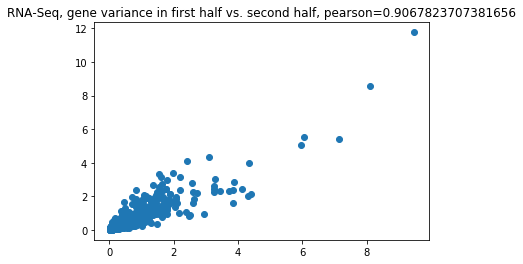

In [184]:
plt.scatter(pQTL_shared_rna_seq_df_first_half_gene_variance,pQTL_shared_rna_seq_df_second_half_gene_variance)
plt.title(f'RNA-Seq, gene variance in first half vs. second half, pearson={pQTL_shared_rna_seq_gene_reliability}')

Text(0.5, 1.0, 'RNA-Seq, Cell variance in first half vs. second half, reliability=0.19614730918473997')

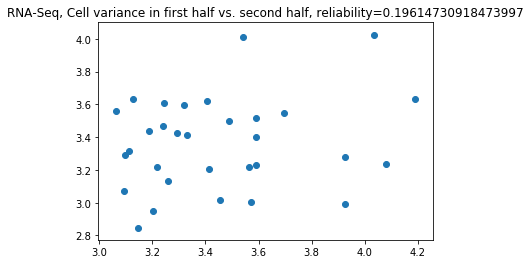

In [160]:
plt.scatter(pQTL_shared_rna_seq_df_first_half_cell_variance,pQTL_shared_rna_seq_df_second_half_cell_variance)
plt.title(f'RNA-Seq, Cell variance in first half vs. second half, reliability={pQTL_shared_rna_seq_cell_reliability}')

In [132]:
shared_protein_feature_cols = np.array(list(filter(lambda x: 'GM' in x,pQTL_shared_protein_df.columns)))
shared_protein_first_half_cols = ['ENSG','Uniprot_Id'] + np.split(shared_protein_feature_cols,2)[0].tolist() 
shared_protein_second_half_cols = ['ENSG','Uniprot_Id']  + np.split(shared_protein_feature_cols,2)[1].tolist()
pQTL_shared_protein_df_first_half = pQTL_shared_protein_df[shared_protein_first_half_cols]
pQTL_shared_protein_df_first_half_feature_matrix = pQTL_shared_protein_df_first_half.iloc[:,2:].to_numpy()
pQTL_shared_protein_df_second_half = pQTL_shared_protein_df[shared_protein_second_half_cols]
pQTL_shared_protein_df_second_half_feature_matrix = pQTL_shared_protein_df_second_half.iloc[:,2:].to_numpy()

In [161]:
pQTL_shared_protein_df_first_half_gene_variance = np.nanvar(pQTL_shared_protein_df_first_half_feature_matrix, axis=1)
pQTL_shared_protein_df_second_half_gene_variance = np.nanvar(pQTL_shared_protein_df_second_half_feature_matrix, axis=1)
pQTL_shared_protein_df_first_half_cell_variance = np.nanvar(pQTL_shared_protein_df_first_half_feature_matrix, axis=0)
pQTL_shared_protein_df_second_half_cell_variance = np.nanvar(pQTL_shared_protein_df_second_half_feature_matrix, axis=0)
pQTL_shared_protein_reliability_col = pQTL_shared_protein_df_first_half_gene_variance/pQTL_shared_protein_df_second_half_gene_variance

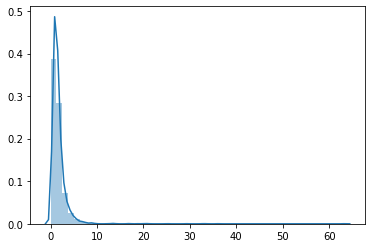

In [174]:
sns.distplot(pQTL_shared_protein_reliability_col)

In [170]:
np.mean(pQTL_shared_protein_df_first_half_gene_variance/pQTL_shared_protein_df_second_half_gene_variance)

1.7023253988556717

In [193]:
pQTL_shared_protein_gene_reliability = np.corrcoef(pQTL_shared_protein_df_first_half_gene_variance,pQTL_shared_protein_df_second_half_gene_variance)[0,1]
pQTL_shared_protein_cell_reliability = np.corrcoef(pQTL_shared_protein_df_first_half_cell_variance,pQTL_shared_protein_df_second_half_cell_variance)[0,1]
print(pQTL_shared_protein_gene_reliability)
print(pQTL_shared_protein_cell_reliability)

0.7299596598335975
0.08752832292445013


Text(0.5, 1.0, 'Protein, gene variance in first half vs. second half, pearson=0.7299596598335975')

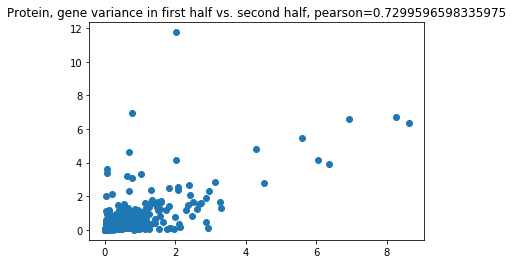

In [188]:
plt.scatter(pQTL_shared_protein_df_first_half_gene_variance,pQTL_shared_protein_df_second_half_gene_variance)
plt.title(f'Protein, gene variance in first half vs. second half, pearson={pQTL_shared_protein_gene_reliability}')

Text(0.5, 1.0, 'Protein, Cell variance in first half vs. second half, reliability=0.7299596598335975')

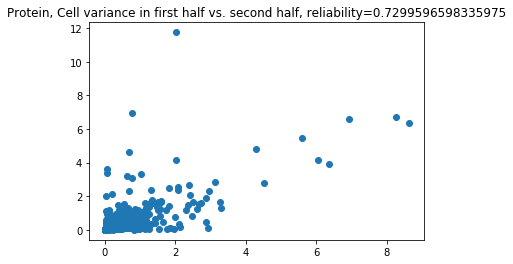

In [136]:
plt.scatter(pQTL_shared_protein_df_first_half_cell_variance,pQTL_shared_protein_df_second_half_cell_variance)
plt.title(f'Protein, Cell variance in first half vs. second half, reliability={pQTL_shared_protein_cell_reliability}')

In [ ]:
pQTL_shared_rna_seq_first_half_cell_variance 

In [4]:
pQTL_shared_rna_seq_df_feature_matrix = pQTL_shared_rna_seq_df.iloc[:,2:].to_numpy()
pQTL_shared_rna_seq_df['gene_median'] = np.nanmedian(pQTL_shared_rna_seq_df_feature_matrix, axis=1)
pQTL_shared_rna_seq_df['gene_mean'] = np.nanmean(pQTL_shared_rna_seq_df_feature_matrix, axis=1)
pQTL_shared_rna_seq_df['gene_variance'] = np.nanvar(pQTL_shared_rna_seq_df_feature_matrix, axis=1)
pQTL_shared_rna_seq_df

,ENSG,Uniprot_Id,GM18486,GM18498,GM18499,GM18501,GM18502,GM18504,GM18505,GM18507,...,GM19200,GM19203,GM19204,GM19207,GM19209,GM19222,GM19257,gene_median,gene_mean,gene_variance
0,ENSG00000000419,O60762,3.403624,5.227954,4.504470,4.953106,4.849282,3.963327,4.969666,5.391710,...,4.622135,5.147009,4.945454,4.558962,4.607702,5.455851,5.244387,4.859673,4.856331,0.172084
1,ENSG00000000457,Q8IZE3,4.840871,4.746018,4.957322,4.732140,4.730582,4.692740,4.999003,4.779415,...,5.140006,4.755334,4.561009,4.917823,4.888944,4.956777,4.896511,4.794210,4.787019,0.070578
2,ENSG00000000938,P09769,6.752102,7.611088,7.067029,7.596479,7.401167,7.943768,6.352896,7.766360,...,8.089803,6.225597,7.132854,7.558977,6.432978,7.002680,7.148120,7.411934,7.289006,0.569579
3,ENSG00000001084,P48506,3.344208,4.448959,3.270660,4.721245,3.709108,3.459819,4.080261,3.932318,...,3.210274,4.245862,3.706022,3.556615,3.437274,4.119904,4.050467,3.734122,3.781333,0.324969
4,ENSG00000001630,Q16850,6.058734,4.756825,5.139635,4.830045,5.713648,5.808345,5.105340,5.454202,...,4.693630,5.273248,5.233983,5.292516,4.870239,5.616429,5.520143,5.179464,5.220378,0.225852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,ENSG00000216490,P13284,8.814517,9.535049,9.498172,9.444232,9.128298,8.270118,9.159325,10.057052,...,9.779241,8.949055,8.525733,9.382265,9.250048,8.983848,10.216222,9.431894,9.407961,0.197746
4252,ENSG00000220205,P63027,5.933303,6.098003,6.704614,5.833831,6.202896,6.936867,6.113701,6.319198,...,6.431118,6.566692,5.962254,6.508231,6.349346,6.078129,6.719185,6.460815,6.446672,0.107987
4253,ENSG00000221823,P63098,4.098423,3.943401,2.894409,3.727635,3.539006,3.043638,3.483677,3.293877,...,2.774491,3.288483,3.691722,3.383378,3.247401,3.943572,2.981313,3.396338,3.399607,0.112228
4254,ENSG00000221914,P63151,5.806963,6.172535,6.596835,6.114805,6.134412,6.022359,6.290200,6.376796,...,6.291605,6.368228,5.982954,5.871401,6.058537,6.696745,6.499732,6.287182,6.273796,0.124699


In [5]:
pQTL_shared_protein_df_feature_matrix = pQTL_shared_protein_df.iloc[:,2:].to_numpy()
pQTL_shared_protein_df['gene_median'] = np.nanmedian(pQTL_shared_protein_df_feature_matrix, axis=1)
pQTL_shared_protein_df['gene_mean'] = np.nanmean(pQTL_shared_protein_df_feature_matrix, axis=1)
pQTL_shared_protein_df['gene_variance'] = np.nanvar(pQTL_shared_protein_df_feature_matrix, axis=1)
pQTL_shared_protein_df

,ENSG,Uniprot_Id,GM18486,GM18498,GM18499,GM18501,GM18502,GM18504,GM18505,GM18507,...,GM19200,GM19203,GM19204,GM19207,GM19209,GM19222,GM19257,gene_median,gene_mean,gene_variance
0,ENSG00000000419,O60762,-0.152939,0.112534,-0.026651,0.242549,-0.187889,-0.349560,0.334760,0.057335,...,-0.126637,0.265958,0.403956,-0.058587,0.281790,-0.197876,-0.130815,0.015366,0.003264,0.050038
1,ENSG00000000457,Q8IZE3,0.791652,NaN,0.223370,0.519652,0.315270,0.183589,0.150964,0.448134,...,0.116232,-0.107043,0.039066,-0.704787,NaN,-0.172065,-0.597988,-0.176120,-0.093277,0.150449
2,ENSG00000000938,P09769,-2.005159,-1.938036,-1.683624,-0.008059,-0.937846,-0.923066,-1.304436,0.243792,...,0.161375,-1.805762,-0.343803,-0.228933,-1.491936,-0.414706,-1.144538,-0.359583,-0.507039,0.571377
3,ENSG00000001084,P48506,-2.120697,-1.606023,NaN,-1.261090,NaN,NaN,-1.180440,-0.483953,...,NaN,-1.323309,-1.332167,-0.879335,-1.250224,-1.360112,-0.817248,-1.325779,-1.277025,0.135819
4,ENSG00000001630,Q16850,0.374041,-0.734608,0.062591,-0.643505,0.039957,NaN,-0.555022,NaN,...,NaN,-0.502627,-0.565275,-1.214427,NaN,NaN,-0.604082,-0.563459,-0.552889,0.158511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,ENSG00000216490,P13284,-1.180284,-1.103504,-1.169102,-0.921147,-1.214965,-1.204776,-1.063123,-0.042103,...,-0.780798,-2.009734,-1.615728,-1.075588,-1.489552,-0.939268,-0.837984,-0.973933,-0.935187,0.248750
4252,ENSG00000220205,P63027,-0.237506,0.091945,0.015566,-0.198844,-0.256989,-0.162317,-0.129742,-0.062626,...,NaN,-0.060852,NaN,-0.136236,NaN,-0.331521,-0.062386,-0.042799,0.078324,0.340816
4253,ENSG00000221823,P63098,-0.206503,NaN,-0.477079,-0.624834,-0.264683,-0.401102,NaN,NaN,...,-0.010800,NaN,NaN,-0.232749,-0.255415,NaN,-0.687597,-0.260049,-0.268362,0.095711
4254,ENSG00000221914,P63151,0.138373,0.021224,-0.141203,-0.158765,-0.067018,-0.110952,-0.118415,-0.324637,...,-0.264977,0.106831,-0.061422,-0.399286,0.212417,-0.190635,-0.241396,-0.131102,-0.143267,0.030044


In [179]:
pQTL_shared_rna_seq_df_cell_mean = np.nanmedian(pQTL_shared_rna_seq_df_feature_matrix, axis=1)
pQTL_shared_rna_seq_df_cell_median = np.nanmean(pQTL_shared_rna_seq_df_feature_matrix, axis=1)
pQTL_shared_rna_seq_df_cell_variance = np.nanvar(pQTL_shared_rna_seq_df_feature_matrix, axis=1)
pQTL_shared_protein_df_cell_mean = np.nanmedian(pQTL_shared_protein_df_feature_matrix, axis=1)
pQTL_shared_protein_df_cell_median = np.nanmean(pQTL_shared_protein_df_feature_matrix, axis=1)
pQTL_shared_protein_df_cell_variance = np.nanvar(pQTL_shared_protein_df_feature_matrix, axis=1)

In [180]:
np.nanmean(pQTL_shared_rna_seq_df_cell_variance/pQTL_shared_protein_df_cell_variance)

3.1887014734532206

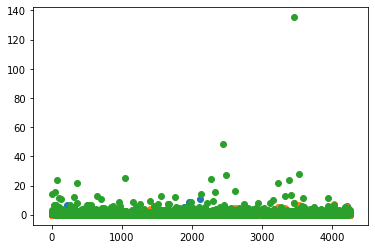

In [56]:
plt.scatter(range(len(pQTL_shared_rna_seq_df_cell_variance)),pQTL_shared_rna_seq_df_cell_variance)
plt.scatter(range(len(pQTL_shared_protein_df_cell_variance)),pQTL_shared_protein_df_cell_variance)
plt.scatter(range(len(pQTL_shared_protein_df_cell_variance)),pQTL_shared_protein_df_cell_variance/pQTL_shared_rna_seq_df_cell_variance)

In [49]:
np.corrcoef(pQTL_shared_rna_seq_df_cell_variance,pQTL_shared_protein_df_cell_variance)[0,1]

0.2775823118113306

(0, 6)

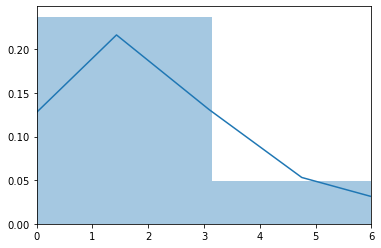

In [53]:
sns.distplot(pQTL_shared_rna_seq_df_cell_variance/pQTL_shared_protein_df_cell_variance)
plt.xlim(0,6)

In [17]:
pQTL_protein_lookup = {p:idx for idx,p in enumerate(pQTL_shared_protein_df['Uniprot_Id'].to_numpy())}

In [164]:
np.corrcoef([pQTL_shared_protein_df['gene_variance'].to_numpy(),pQTL_shared_rna_seq_df['gene_variance'].to_numpy()])

array([[1.        , 0.27758231],
       [0.27758231, 1.        ]])

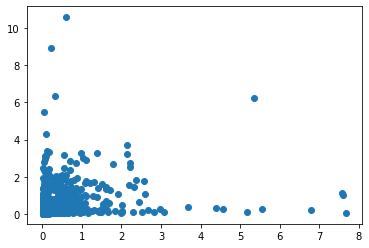

In [165]:
plt.scatter(pQTL_shared_protein_df['gene_variance'].to_numpy(),pQTL_shared_rna_seq_df['gene_variance'].to_numpy())

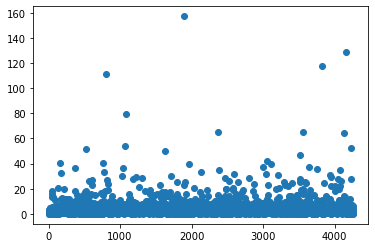

In [151]:
plt.scatter(range(len(pQTL_shared_rna_seq_df_cell_variance)),pQTL_shared_rna_seq_df_cell_variance / pQTL_shared_protein_df_cell_variance)

In [11]:
from scipy import stats
per_gene_pearson = []
per_gene_spearman = []
for i in range(len(pQTL_shared_rna_seq_df)):
    rna_seq_row = pQTL_shared_rna_seq_df_feature_matrix[i]
    protein_row = pQTL_shared_protein_df_feature_matrix[i]
    nas = np.logical_or(np.isnan(rna_seq_row), np.isnan(protein_row))
    pearson = np.corrcoef(rna_seq_row[~nas], protein_row[~nas])[0,1]
    spearman = stats.spearmanr(rna_seq_row[~nas], protein_row[~nas])[0]
    per_gene_pearson.append(pearson)
    per_gene_spearman.append(spearman)

In [12]:
np.nanmedian(per_gene_pearson)

0.13987587254064504

In [68]:
np.nanmedian(per_gene_spearman)

0.14109129360190226

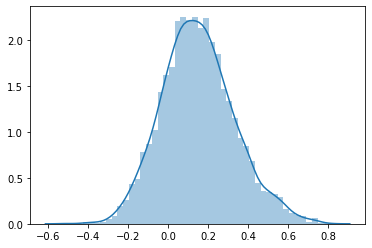

In [16]:
sns.distplot(per_gene_spearman)

In [64]:
per_cell_pearson = []
per_cell_spearman = []
for i in range(pQTL_shared_rna_seq_df_feature_matrix.shape[1]):
    rna_seq_col = pQTL_shared_rna_seq_df_feature_matrix[:,i]
    protein_col = pQTL_shared_protein_df_feature_matrix[:,i]
    nas = np.logical_or(np.isnan(rna_seq_col), np.isnan(protein_col))
    pearson = np.corrcoef(rna_seq_col[~nas], protein_col[~nas])[0,1]
    spearman = stats.spearmanr(rna_seq_col[~nas], protein_col[~nas])[0]
    per_cell_pearson.append(pearson)
    per_cell_spearman.append(spearman)

4000
3775
3980
3967
4059
3984
3829
3867
4014
3974
3945
3792
3898
3886
3952
3820
3855
3873
4153
3821
3999
3889
3994
3307
3890
3921
3907
3912
3910
3843
3984
3894
3970
3891
3857
3835
4141
3833
3942
3928
3891
3751
3793
3987
4136
3905
3642
3720
3934
3872
3925
4017
3784
3820
3763
3778
3943
3969
3959
3850
3974
3905


In [67]:
np.nanmedian(per_cell_spearman)

-0.03421720261360346

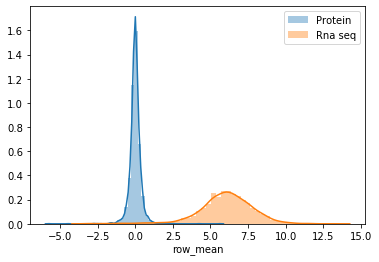

In [125]:
sns.distplot(pQTL_shared_protein_df['row_mean'],label="Protein",norm_hist=True)
sns.distplot(pQTL_shared_rna_seq_df['row_mean'],label="Rna seq",norm_hist=True)
plt.legend()

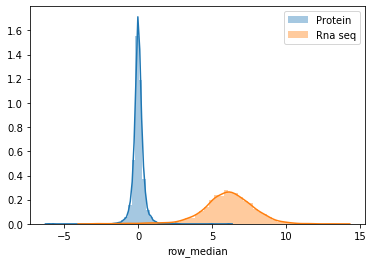

In [130]:
sns.distplot(pQTL_shared_protein_df['row_median'],label="Protein",norm_hist=True)
sns.distplot(pQTL_shared_rna_seq_df['row_median'],label="Rna seq",norm_hist=True)
plt.legend()

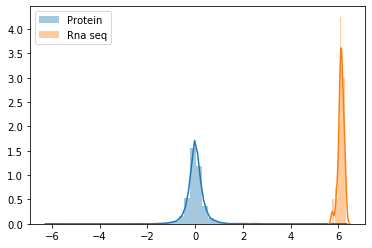

In [127]:
sns.distplot(pQTL_shared_protein_df_col_mean,label="Protein",norm_hist=True)
sns.distplot(pQTL_shared_rna_seq_df_col_mean,label="Rna seq",norm_hist=True)
plt.legend()

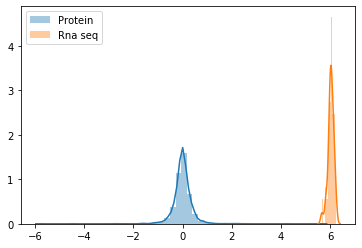

In [137]:
sns.distplot(pQTL_shared_protein_df_col_median,label="Protein",norm_hist=True)
sns.distplot(pQTL_shared_rna_seq_df_col_median,label="Rna seq",norm_hist=True)
plt.legend()

In [133]:
pQTL_shared_rna_seq_df_col_median

array([5.84088091, 6.17340439, 5.97936941, 6.15411621, 6.07750191,
       5.82126667, 6.14345383, 6.14000927, 6.10503641, 6.00929895,
       6.08679475, 6.03658602, 6.06981238, 5.9621146 , 5.95366683,
       6.23754492, 5.99540778, 5.97970028, 5.82821073, 6.02258719,
       6.21345058, 6.0193436 , 5.99174361, 5.98227335, 5.81695968,
       6.08999626, 6.0176367 , 5.89078141, 6.1296805 , 5.90824568,
       6.1133846 , 6.17600131, 6.16931332, 6.17314927, 6.04733022,
       6.16402911, 5.66368154, 6.06854888, 6.14762427, 6.04679572,
       6.02947623, 6.2530473 , 6.03697435, 6.06614828, 6.00963658,
       6.0815496 , 6.04630633, 5.95352608, 6.02472722, 6.07114858,
       6.10924329, 5.95403028, 5.9696501 , 6.00869788, 5.67372275,
       5.9557342 , 6.02010422, 6.09870364, 6.03163055, 5.92576425,
       6.21895834, 6.04280137])

In [134]:
pQTL_shared_protein_df_col_median

array([ 0.0032638 , -0.09327719, -0.50703917, ..., -0.26836214,
       -0.14326743, -0.0813572 ])

In [117]:
np.mean(pQTL_shared_protein_df['row_median'] / pQTL_shared_rna_seq_df['row_median'])

0.0009608062311313581

In [2]:
pQTL_protein_pairs_df_validated = pd.read_csv(f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_pairs_validated.csv")
pQTL_rna_seq_pearson_lookup = read_json_from(f"{PATH_ROOT}/data_sources/pQTL/pQTL_rna_seq_pairs_validated.json")

In [3]:
pQTL_protein_pairs_df_validated_cocomplex = pQTL_protein_pairs_df_validated[pQTL_protein_pairs_df_validated['cocomplex'] == 1]
pQTL_protein_pairs_df_validated_cocomplex

,protein_1,protein_2,euclidean,pearson,binary_interaction,cocomplex
3837,O60762,Q9P2X0,2.094235,0.794469,1,1
13124,P48506,P48507,8.572548,-0.094519,0,1
29244,Q9Y6D9,Q13257,2.948131,0.409122,1,1
68473,P54819,Q13158,3.616486,0.196743,0,1
78527,O60341,P51531,5.399765,0.320704,0,1
...,...,...,...,...,...,...
18796377,P62987,P61513,1.559279,0.344924,1,1
18796389,P62987,P30050,0.798080,0.802118,1,1
18796406,P62987,P62750,0.893168,0.853275,1,1
18796433,P62987,P62906,0.783644,0.854695,1,1


In [7]:
pQTL_rna_protein_shared_df = pd.DataFrame(data=keep_tuples,columns=['protein_1','protein_2','protein_pearson','rna_seq_pearson'])
pQTL_rna_protein_shared_df

,protein_1,protein_2,protein_pearson,rna_seq_pearson
0,O60762,Q9P2X0,0.794469,0.268145
1,P48506,P48507,-0.094519,0.455288
2,Q9Y6D9,Q13257,0.409122,-0.350401
3,P54819,Q13158,0.196743,0.224964
4,O60341,P51531,0.320704,0.159963
...,...,...,...,...
44185,P62987,P61513,0.344924,0.112363
44186,P62987,P30050,0.802118,0.126002
44187,P62987,P62750,0.853275,-0.166032
44188,P62987,P62906,0.854695,0.696072


In [68]:
from validation import is_hit,all_complex_id_to_subunits
# big_ids = []
# big_subunit_lens = []
found_in = []
for idx,row in pQTL_rna_protein_shared_df.iterrows():
    complexes_hit = is_hit([row['protein_1'],row['protein_2']],return_complexes=True)
    complexes_hit = list(map(lambda x: str(x),complexes_hit))
    found_in.append(";".join(complexes_hit))
# #     biggest_complex_id = complexes_hit[0]
# #     biggest_complex_subunits_len = len(all_complex_id_to_subunits[str(biggest_complex_id)])
#     for com in complexes_hit:
#         if len(all_complex_id_to_subunits[str(com)]) > biggest_complex_subunits_len:
#             biggest_complex_id = com
#             biggest_complex_subunits_len = len(all_complex_id_to_subunits[str(biggest_complex_id)])
#     big_ids.append(biggest_complex_id)
#     big_subunit_lens.append(biggest_complex_subunits_len)
found_in

['5244',
 '7186',
 '1814',
 '5856',
 '1257',
 '1257',
 '1257',
 '1257',
 '614;632',
 '614;620;626;632;633;634;636;642;643;646;648;871;1257;1492',
 '1257',
 '626;632;633;1492',
 '1257',
 '1257',
 '646',
 '1257',
 '626',
 '632;646;1257',
 '1257',
 '642',
 '1257',
 '626;642;643',
 '614;632;646;1257',
 '1257',
 '1257',
 '632;1257',
 '614;632;646;1257',
 '1257',
 '642;643',
 '614;632',
 '1257',
 '614;620;632;633;634;636;642;643;871;1257;1492',
 '642;643',
 '6459',
 '6459',
 '178',
 '178;2914',
 '178;2914',
 '178;2914',
 '178',
 '178',
 '178;2914',
 '178',
 '178',
 '178',
 '178',
 '178;2914',
 '178',
 '178;2914',
 '178',
 '178;2914',
 '178;2914',
 '178',
 '178',
 '178',
 '178;2914',
 '178;2914',
 '178',
 '178',
 '178',
 '178',
 '178',
 '178;2914',
 '178',
 '178',
 '178;2914',
 '178',
 '93;96',
 '93;96',
 '93;96',
 '93;96;5361',
 '93;96',
 '96',
 '93;96',
 '93;96;5361',
 '822',
 '784',
 '7030',
 '822',
 '784',
 '822',
 '822',
 '812;813;814;822',
 '784',
 '814',
 '822',
 '822',
 '814',
 '103;1

In [18]:
pQTL_rna_protein_shared_df = pd.read_csv(f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_rna_shared_cocomplex_pairs.csv")
pQTL_rna_protein_shared_df_found_in_size = list(map(lambda x: len(x.split(";")),pQTL_rna_protein_shared_df['found_in'].to_numpy()))
pQTL_rna_protein_shared_df['found_in_size'] = pQTL_rna_protein_shared_df_found_in_size
pQTL_rna_protein_shared_df

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,found_in_size
0,O60762,Q9P2X0,0.794469,0.268145,5244,5244,3,1
1,P48506,P48507,-0.094519,0.455288,7186,7186,2,1
2,Q9Y6D9,Q13257,0.409122,-0.350401,1814,1814,2,1
3,P54819,Q13158,0.196743,0.224964,5856,5856,3,1
4,O60341,P51531,0.320704,0.159963,1257,1257,28,1
...,...,...,...,...,...,...,...,...
44185,P62987,P61513,0.344924,0.112363,306;308,306,80,2
44186,P62987,P30050,0.802118,0.126002,306;308,306,80,2
44187,P62987,P62750,0.853275,-0.166032,306;308,306,80,2
44188,P62987,P62906,0.854695,0.696072,306;308,306,80,2


In [25]:
p1_across_vals = []
p2_across_vals = []
for idx,row in pQTL_rna_protein_shared_df.iterrows():
    p1 = row['protein_1']
    p2 = row['protein_2']
    p1_across = per_gene_pearson[pQTL_protein_lookup[p1]]
    p2_across = per_gene_pearson[pQTL_protein_lookup[p2]]
    p1_across_vals.append(p1_across)
    p2_across_vals.append(p2_across)

In [26]:
pQTL_rna_protein_shared_df['p1_rna_protein_corr'] = p1_across_vals
pQTL_rna_protein_shared_df['p2_rna_protein_corr'] = p2_across_vals
pQTL_rna_protein_shared_df

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,found_in_size,p1_rna_protein_corr,p2_rna_protein_corr
0,O60762,Q9P2X0,0.794469,0.268145,5244,5244,3,1,-0.076347,0.160795
1,P48506,P48507,-0.094519,0.455288,7186,7186,2,1,0.365057,0.246732
2,Q9Y6D9,Q13257,0.409122,-0.350401,1814,1814,2,1,0.119428,0.089644
3,P54819,Q13158,0.196743,0.224964,5856,5856,3,1,-0.043574,-0.023252
4,O60341,P51531,0.320704,0.159963,1257,1257,28,1,0.103395,0.637288
...,...,...,...,...,...,...,...,...,...,...
44185,P62987,P61513,0.344924,0.112363,306;308,306,80,2,0.005698,0.087955
44186,P62987,P30050,0.802118,0.126002,306;308,306,80,2,0.005698,0.133762
44187,P62987,P62750,0.853275,-0.166032,306;308,306,80,2,0.005698,0.134732
44188,P62987,P62906,0.854695,0.696072,306;308,306,80,2,0.005698,0.084349


In [31]:
seen = set()
dup_idx = []
for idx,row in pQTL_rna_protein_shared_df.iterrows():
    p1 = row['protein_1']
    p2 = row['protein_2']
    comb = p1+";"+p2
    if comb not in seen:
        seen.add(p1+";"+p2)
        seen.add(p2+";"+p1)
    else:
        dup_idx.append(idx)
print(len(dup_idx))

22095


In [34]:
pQTL_rna_protein_shared_df = pQTL_rna_protein_shared_df.iloc[dup_idx]

In [35]:
pQTL_rna_protein_shared_df.describe()

,protein_pearson,rna_seq_pearson,biggest_complex_id,biggest_complex_size,found_in_size,p1_rna_protein_corr,p2_rna_protein_corr
count,22095.000000,22095.000000,22095.000000,22095.000000,22095.000000,22095.000000,22095.000000
mean,0.413615,0.184990,1575.599502,85.103824,1.593890,0.082981,0.099583
std,0.323662,0.348406,1820.614901,51.667128,1.637666,0.142351,0.146489
min,-0.732151,-0.865309,4.000000,2.000000,1.000000,-0.458156,-0.458156
25%,0.168929,-0.056160,351.000000,30.000000,1.000000,-0.006114,0.008706
50%,0.439498,0.202246,351.000000,104.000000,1.000000,0.084349,0.098498
75%,0.683693,0.453824,3055.000000,143.000000,2.000000,0.165935,0.186743
max,0.997545,0.939809,7593.000000,143.000000,42.000000,0.749353,0.749353


In [147]:
# check absolute difference
# remove ribosome proteins
# check if cellular location affects anything?
# pQTL_shared_filtered = pQTL_rna_protein_shared_df.loc[~pQTL_rna_protein_shared_df['found_in'].str.contains('306') | pQTL_rna_protein_shared_df['found_in'].str.contains('3066')]
# pQTL_shared_filtered = pQTL_shared_filtered[(pQTL_shared_filtered['protein_pearson'] - pQTL_shared_filtered['rna_seq_pearson']) > 1]
# pQTL_shared_filtered = pQTL_shared_filtered[pQTL_shared_filtered['biggest_complex_size'] <= 5]
# pQTL_shared_filtered
#pQTL_shared_filtered = pQTL_rna_protein_shared_df[(pQTL_rna_protein_shared_df['protein_pearson'] - pQTL_rna_protein_shared_df['rna_seq_pearson']) > 1]

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,found_in_size
292,O75534,P11940,0.712442,-0.422444,1307,1307,5,1
2967,P11940,O75534,0.712442,-0.422444,1307,1307,5,1
5167,Q9Y224,Q9Y3I0,0.746496,-0.495128,6301,6301,5,1
5936,Q9Y5B9,P67870,0.696628,-0.487032,938,938,5,1
7659,Q9Y3I0,Q9Y224,0.746496,-0.495128,6301,6301,5,1
7917,Q9H1I8,Q8N3C0,0.638113,-0.525318,1377,1377,4,1
13567,Q8N3C0,Q9H1I8,0.638113,-0.525318,1377,1377,4,1
43455,P67870,Q9Y5B9,0.696628,-0.487032,938,938,5,1


In [197]:
#Cocomplex pairs that correlate strongly in rna seq but weakly in protein
# pQTL_shared_filtered = pQTL_rna_protein_shared_df.loc[(pQTL_rna_protein_shared_df['protein_pearson'] <= 0.25) & (pQTL_rna_protein_shared_df['protein_pearson'] >= -0.25)]
# pQTL_shared_filtered = pQTL_shared_filtered.loc[(pQTL_shared_filtered['rna_seq_pearson'] >= 0.5) | (pQTL_shared_filtered['rna_seq_pearson'] <= -0.5)]
# pQTL_shared_filtered

# Cocomplex pairs that correlate strongly in protein but weakly in rna seq
# pQTL_shared_filtered = pQTL_rna_protein_shared_df.loc[(pQTL_rna_protein_shared_df['protein_pearson'] >= 0.5) | (pQTL_rna_protein_shared_df['protein_pearson'] <= -0.5)]
# pQTL_shared_filtered = pQTL_shared_filtered.loc[(pQTL_shared_filtered['rna_seq_pearson'] <= 0.25) & (pQTL_shared_filtered['rna_seq_pearson'] >= -0.25)]
# pQTL_shared_filtered

#Cocomplex pairs that weakly correlates in both protein and rna seq
pQTL_shared_filtered = pQTL_rna_protein_shared_df.loc[(pQTL_rna_protein_shared_df['protein_pearson'] <= 0.25) & (pQTL_rna_protein_shared_df['protein_pearson'] >= -0.25)]
pQTL_shared_filtered = pQTL_shared_filtered.loc[(pQTL_shared_filtered['rna_seq_pearson'] <= 0.25) & (pQTL_shared_filtered['rna_seq_pearson'] >= -0.25)]
pQTL_shared_filtered

# Cocomplex pairs that correlate strongly in both protein and rna seq
# pQTL_shared_filtered = pQTL_rna_protein_shared_df.loc[(pQTL_rna_protein_shared_df['protein_pearson'] >= 0.5) | (pQTL_rna_protein_shared_df['protein_pearson'] <= -0.5)]
# pQTL_shared_filtered = pQTL_shared_filtered.loc[(pQTL_shared_filtered['rna_seq_pearson'] >= 0.5) | (pQTL_shared_filtered['rna_seq_pearson'] <= -0.5)]
# pQTL_shared_filtered

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,found_in_size,p1_rna_protein_corr,p2_rna_protein_corr
463,P43686,P20618,0.028618,0.186105,181;193,193,36,2,-0.013458,0.099068
897,P35251,Q14181,-0.096542,0.200702,1003;1098;1099;1107;1108;1111,1099,17,6,0.416684,0.116533
1086,Q96T60,P49916,0.172377,-0.120613,362;5243,362,4,2,-0.052428,0.119702
1092,P25789,P43686,-0.031338,0.090483,181;193,193,36,2,0.061456,-0.013458
1126,Q9NUW8,Q96T60,0.034395,-0.137030,5243,5243,4,1,0.407281,-0.052428
...,...,...,...,...,...,...,...,...,...,...
44106,Q9H269,Q8WUH2,0.172995,-0.069821,6388,6388,6,1,0.116874,-0.053949
44112,Q9H269,Q86VS8,0.041029,-0.004972,6122,6122,2,1,0.116874,0.045396
44113,P63027,O00161,-0.153483,0.023415,731;797,731,3,2,0.353015,0.131340
44115,P63027,Q86Y82,-0.052840,0.115425,707;1874,1874,5,2,0.353015,0.053285


In [46]:
pQTL_shared_filtered.describe()

,protein_pearson,rna_seq_pearson,biggest_complex_id,biggest_complex_size,found_in_size,p1_rna_protein_corr,p2_rna_protein_corr
count,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000
mean,0.062722,0.020246,1741.170166,80.439361,1.413037,0.107395,0.122392
std,0.125544,0.139684,2043.529573,59.229896,1.417050,0.172715,0.171170
min,-0.248601,-0.249963,58.000000,2.000000,1.000000,-0.458156,-0.372627
25%,-0.024783,-0.093884,351.000000,16.000000,1.000000,-0.002776,0.007981
50%,0.081500,0.029306,493.000000,104.000000,1.000000,0.094439,0.106997
75%,0.167523,0.139649,3055.000000,143.000000,1.000000,0.205461,0.223261
max,0.249872,0.249749,7593.000000,143.000000,25.000000,0.714877,0.749353


In [ ]:
# 95% cocomplex pairs are found in only 1 complex
# Cocomplex pairs that weakly correlates in both protein and rna seq (< +-0.1)tend to come from big complex pairs (verify with control)

In [200]:
np.unique(pQTL_shared_filtered['biggest_complex_size'].to_numpy(),return_counts=True)

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  22,  23,  25,  26,  27,  28,  30,
         32,  33,  36,  37,  44,  78,  80, 104, 143], dtype=int64),
 array([  20,  101,   76,   59,   44,   56,   46,   41,   58,   19,   44,
          47,   84,   64,  100,   56,   35,   21,    4,   15,   21,   56,
          23,   20,   34,   37,   41,   19,   69,   85,    2,   84,   95,
         296, 1319], dtype=int64))

In [140]:
pQTL_rna_protein_shared_df[pQTL_rna_protein_shared_df['found_in'].str.contains('3066')]

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,found_in_size
116,Q92793,P51531,0.269888,0.138956,3066,3066,13,1
117,Q92793,Q12824,0.486912,-0.326804,570;3061;3062;3066,3066,13,4
121,Q92793,Q13889,0.116347,-0.131121,3066,3066,13,1
122,Q92793,P24863,0.102991,-0.506791,3061;3066,3066,13,2
127,Q92793,P35269,0.079318,0.301184,3066,3066,13,1
...,...,...,...,...,...,...,...,...
39999,P24928,P35269,0.197580,0.463341,103;2685;2825;3060;3064;3066;5363,2825,26,7
40004,P24928,P51532,0.472305,0.382829,3066,3066,13,1
40009,P24928,Q00403,0.657381,-0.356061,103;1749;2685;2825;3064;3066,2825,26,6
40022,P24928,Q13503,0.300574,-0.448976,2825;3060;3064;3066,2825,26,4


In [40]:
found_in_sizes,found_in_counts = np.unique(pQTL_rna_protein_shared_df['found_in_size'].to_numpy(), return_counts=True)
found_in_size_med_protein = []
found_in_size_med_rna_seq = []
for size in found_in_sizes:
    temp_df = pQTL_rna_protein_shared_df[pQTL_rna_protein_shared_df['found_in_size'] == size]
    temp_df_p_pearson = temp_df['protein_pearson'].to_numpy()
    temp_df_r_pearson = temp_df['rna_seq_pearson'].to_numpy()
    found_in_size_med_protein.append(np.median(temp_df_p_pearson))
    found_in_size_med_rna_seq.append(np.median(temp_df_r_pearson))

In [41]:
found_in_counts

array([15249,  4281,  1412,   519,   319,    89,    49,    29,    16,
          28,    18,     5,     9,     7,     5,     2,     7,     4,
           5,     3,     5,     4,     5,     5,     4,     4,     1,
           3,     1,     1,     2,     2,     1,     1], dtype=int64)

In [196]:
(15249+4281+1412+519+319)

21780

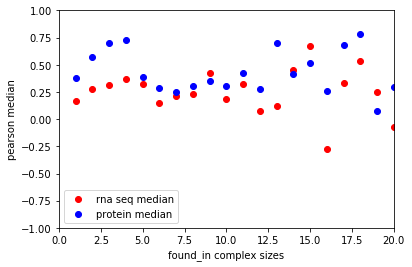

In [44]:
plt.scatter(found_in_sizes,found_in_size_med_rna_seq,c='red',label='rna seq median')
plt.scatter(found_in_sizes,found_in_size_med_protein,c='blue',label='protein median')
plt.ylim((-1,1))
plt.xlim((0,20))
# plt.xlim((0,6.5))
plt.xlabel('found_in complex sizes')
plt.ylabel('pearson median')
plt.legend()

0.19718160343289626
0.1389135692956786


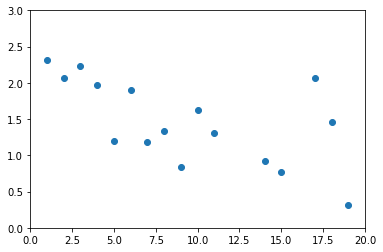

In [131]:
protein_med_over_rna_med = np.array(found_in_size_med_protein) / np.array(found_in_size_med_rna_seq)
#gradient, intercept, r_value, p_value, std_err = stats.linregress(found_in_sizes,protein_med_over_rna_med)
print(p_value)
print(std_err)
plt.ylim((0,3))
plt.xlim((0,20))
#plt.ylim((1,3))
# plt.xlim((0,6.5))
#coef = np.polyfit(found_in_size_med_protein,protein_med_over_rna_med,1)
#poly1d_fn = np.poly1d(coef) 
#plt.plot(found_in_sizes,protein_med_over_rna_med, 'o', found_in_sizes, poly1d_fn(found_in_sizes), '--k')
plt.scatter(found_in_sizes,protein_med_over_rna_med)

In [111]:
protein_med_over_rna_med

array([  2.32059162,   2.06702289,   2.2338407 ,   1.97091781,
         1.19540775,   1.9003711 ,   1.18248272,   1.3301878 ,
         0.83269719,   1.63031238,   1.31117318,   3.70339208,
         5.95214444,   0.92719295,   0.7630273 ,  -0.92677228,
         2.07326762,   1.45578479,   0.31224813,  -4.3008736 ,
        -1.05613033,   1.69675985,   0.37977154,   0.55421401,
         2.38933567, -48.87657023, -12.34187028,   2.39277152,
         1.90729756,   0.75595747,   0.66999033,  -3.07089253,
         2.40248989,   0.2675038 ])

In [45]:
unique_com_sizes = np.unique(pQTL_rna_protein_shared_df['complex_size'])
size_med_protein = []
size_med_rna_seq = []
for num in unique_com_sizes:
    temp_df = pQTL_rna_protein_shared_df[pQTL_rna_protein_shared_df['complex_size'] == num]
    temp_df_p_pearson = temp_df['protein_pearson'].to_numpy()
    temp_df_r_pearson = temp_df['rna_seq_pearson'].to_numpy()
    size_med_protein.append(np.median(temp_df_p_pearson))
    size_med_rna_seq.append(np.median(temp_df_r_pearson))

In [46]:
size_med_rna_seq

[0.16814370100058793,
 0.15546231494148394,
 0.1163942854636877,
 0.2631626144154961,
 0.26853286855072867,
 0.2879967178870925,
 0.2304552246307961,
 0.25345465505561315,
 0.2870774383427777,
 0.367331228931249,
 0.28256556027907537,
 0.15128944033449834,
 0.146252501420613,
 0.2225718856140446,
 0.17238266260575624,
 0.18185689849500908,
 0.25726597134136364,
 0.09306136654203112,
 0.3597463939687775,
 0.18799085825029305,
 0.2670494576724093,
 -0.07799981488675453,
 0.047250451617089156,
 0.16118069459337503,
 0.2852439690435526,
 0.1132212295445687,
 0.10059389469249952,
 0.047570073678182986,
 0.1971344305973596,
 0.4800047679562654,
 0.16907472073759006,
 0.3300336573910324,
 -0.11790531049686405,
 0.3056222375258265,
 0.35617569688929873,
 0.16673268130002256,
 0.13358574137499954]

In [42]:
pQTL_rna_protein_shared_df[pQTL_rna_protein_shared_df['complex_size'] <= 80]

,protein_1,protein_2,protein_pearson,rna_seq_pearson,complex_id,complex_size
0,O60762,Q9P2X0,0.794469,0.268145,5244,3
1,P48506,P48507,-0.094519,0.455288,7186,2
2,Q9Y6D9,Q13257,0.409122,-0.350401,1814,2
3,P54819,Q13158,0.196743,0.224964,5856,3
4,O60341,P51531,0.320704,0.159963,1257,28
...,...,...,...,...,...,...
44185,P62987,P61513,0.344924,0.112363,306,80
44186,P62987,P30050,0.802118,0.126002,306,80
44187,P62987,P62750,0.853275,-0.166032,306,80
44188,P62987,P62906,0.854695,0.696072,306,80


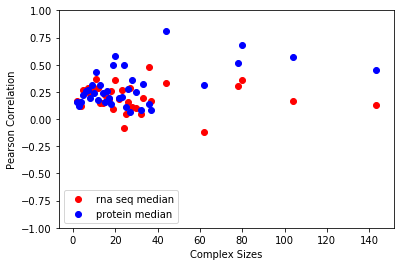

In [61]:
# plt.scatter(pQTL_rna_protein_shared_df['complex_size'],pQTL_rna_protein_shared_df['rna_seq_pearson'])
plt.scatter(unique_com_sizes,size_med_rna_seq,c='red',label='rna seq median')
plt.scatter(unique_com_sizes,size_med_protein,c='blue',label='protein median')
plt.xlabel('Complex Sizes')
plt.ylabel('Pearson Correlation')
plt.ylim((-1,1))
plt.legend(loc='lower left')

0.2198847560582904
0.009902089604227416


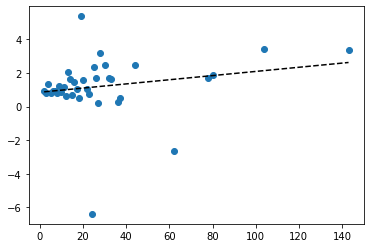

In [66]:
from scipy import stats
gradient, intercept, r_value, p_value, std_err = stats.linregress(unique_com_sizes,protein_med_over_rna_med)
print(p_value)
print(std_err)
protein_med_over_rna_med = np.array(size_med_protein) / np.array(size_med_rna_seq)
coef = np.polyfit(unique_com_sizes,protein_med_over_rna_med,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(unique_com_sizes,protein_med_over_rna_med, 'o', unique_com_sizes, poly1d_fn(unique_com_sizes), '--k')
#plt.scatter(unique_com_sizes,protein_med_over_rna_med,c='green')

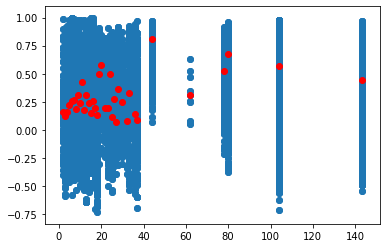

In [49]:
plt.scatter(pQTL_rna_protein_shared_df['complex_size'],pQTL_rna_protein_shared_df['protein_pearson'])
plt.scatter(unique_com_sizes,size_med_protein,c='red')

In [10]:
pQTL_rna_protein_shared_df_np = pQTL_rna_protein_shared_df.iloc[:,2:].to_numpy()
pQTL_rna_protein_shared_df_np

array([[ 0.79446886,  0.2681449 ],
       [-0.0945194 ,  0.45528781],
       [ 0.40912171, -0.35040054],
       ...,
       [ 0.85327517, -0.16603174],
       [ 0.85469518,  0.69607153],
       [ 0.74854928,  0.28639084]])

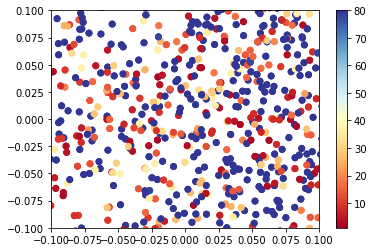

In [187]:
from matplotlib import pyplot as plt
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(pQTL_rna_protein_shared_df_np[:,0],
            pQTL_rna_protein_shared_df_np[:,1],
            c=pQTL_rna_protein_shared_df['biggest_complex_size'].to_numpy(),
            vmin=1,
            vmax=80,
            cmap=cm
           )
plt.ylim((-0.1,0.1))
plt.xlim((-0.1,0.1))
plt.colorbar(sc)
plt.show()

In [ ]:
pQTL_filtered = pQTL_rna_protein_shared_df
plt.scatter(pQTL_rna_protein_shared_df_np[:,0],pQTL_rna_protein_shared_df_np[:,1],c=pQTL_rna_protein_shared_df['biggest_complex_size'].to_numpy())

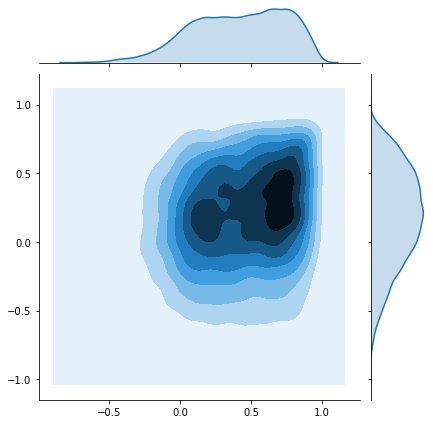

In [14]:
sns.jointplot(pQTL_rna_protein_shared_df_np[:,0],pQTL_rna_protein_shared_df_np[:,1], kind="kde")

In [46]:
pQTL_rna_protein_shared_df = pd.read_csv(f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_rna_shared_cocomplex_pairs.csv")

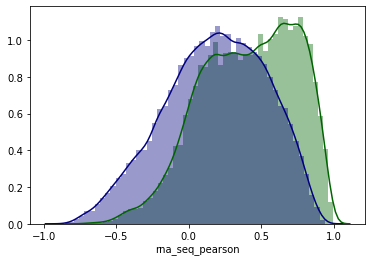

In [47]:
import seaborn as sns
sns.distplot( pQTL_rna_protein_shared_df['protein_pearson'] , color="darkgreen", label="Protein pairs",norm_hist=True)
sns.distplot( pQTL_rna_protein_shared_df['rna_seq_pearson'] , color="navy", label="Rna seq pairs",norm_hist=True)

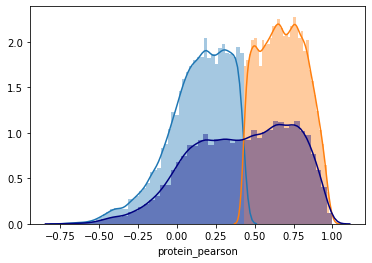

In [76]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture
protein_person = pQTL_rna_protein_shared_df['protein_pearson'].to_numpy().reshape(-1,1)
gmm = GaussianMixture(n_components=2)
gmm.fit(protein_person)
#predictions from gmm
labels = gmm.predict(protein_person)
pQTL_rna_protein_shared_df['protein_cluster_label'] = labels
for lab in np.unique(labels):
    temp_df = pQTL_rna_protein_shared_df[pQTL_rna_protein_shared_df['protein_cluster_label'] == lab]
    sns.distplot(temp_df['protein_pearson'],label="Protein pairs")
sns.distplot( pQTL_rna_protein_shared_df['protein_pearson'] , color="navy", label="Rna seq pairs")

In [80]:
pQTL_rna_protein_shared_df.loc[(pQTL_rna_protein_shared_df['protein_cluster_label'] == 0) & (pQTL_rna_protein_shared_df['biggest_complex_size'] <= 5)]

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,protein_cluster_label
1,P48506,P48507,-0.094519,0.455288,7186,7186,2,0
2,Q9Y6D9,Q13257,0.409122,-0.350401,1814,1814,2,0
3,P54819,Q13158,0.196743,0.224964,5856,5856,3,0
77,Q92900,P04150,0.025585,0.010287,7030,7030,4,0
83,Q92900,Q96Q15,0.268948,0.225336,784,784,4,0
...,...,...,...,...,...,...,...,...
44115,P63027,Q86Y82,-0.052840,0.115425,707;1874,1874,5,0
44116,P63098,P62942,-0.102438,0.436056,6374,6374,3,0
44119,P63151,P67775,0.326499,0.565903,7005,7005,4,0
44120,P63151,Q13526,0.277122,-0.664771,5211,5211,5,0


In [81]:
pQTL_rna_protein_shared_df.loc[(pQTL_rna_protein_shared_df['protein_cluster_label'] == 1) & (pQTL_rna_protein_shared_df['biggest_complex_size'] <= 5)]

,protein_1,protein_2,protein_pearson,rna_seq_pearson,found_in,biggest_complex_id,biggest_complex_size,protein_cluster_label
0,O60762,Q9P2X0,0.794469,0.268145,5244,5244,3,1
33,Q96JG6,Q5VIR6,0.601154,0.040562,6459,6459,4,1
34,Q96JG6,Q9UID3,0.593365,-0.179356,6459,6459,4,1
76,Q92900,P15170,0.708873,0.342493,784,784,4,1
79,Q92900,P62495,0.583478,0.137081,784,784,4,1
...,...,...,...,...,...,...,...,...
43914,O75489,Q15388,0.445713,0.260119,2938,2938,3,1
44101,Q99623,P45880,0.878499,0.075660,6289,6289,5,1
44102,Q99623,P35232,0.975796,0.241844,6289,6289,5,1
44117,P63098,Q08209,0.445373,0.302702,6023;6374,6374,3,1


In [28]:
pQTL_df_validated_positives = pQTL_df_validated[pQTL_df_validated['binary_interaction']==1]
pQTL_df_validated_negatives = pQTL_df_validated[pQTL_df_validated['binary_interaction']==0]

In [49]:
from util import get_new_sampled_dataset
sampled_df = get_new_sampled_dataset(pQTL_df_validated_positives,10000,pQTL_df_validated_negatives,10000)

In [50]:
sampled_df['euclidean_inverted'] = 1/sampled_df['euclidean'].to_numpy()

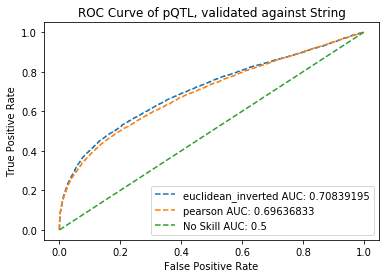

[0.70839195, 0.69636833, 0.5]

In [55]:
df_roc_analysis(sampled_df,['euclidean_inverted','pearson'],'binary_interaction','pQTL','String')

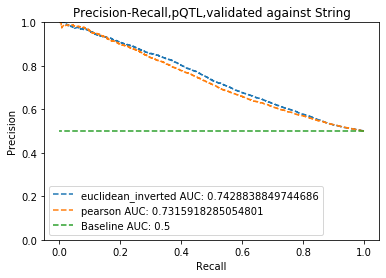

[0.7428838849744686, 0.7315918285054801, 0.5]

In [56]:
df_precision_recall_analysis(sampled_df,['euclidean_inverted','pearson'],
                             'binary_interaction',
                            'Precision-Recall,pQTL,validated against String',
                            ylim=(0,1))

In [21]:
pQTL_rna_seq_df_validated_cocomplex = pQTL_rna_seq_df_validated[pQTL_rna_seq_df_validated['cocomplex'] == 1]
pQTL_rna_seq_df_validated_non_complex = pQTL_rna_seq_df_validated[pQTL_rna_seq_df_validated['cocomplex'] == 0]

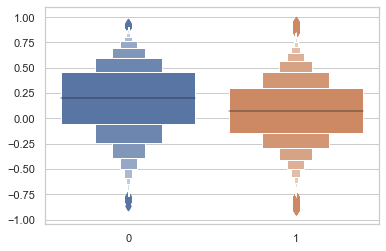

In [22]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_rna_seq_df_validated_cocomplex['pearson'].to_numpy(),pQTL_rna_seq_df_validated_non_complex['pearson'].to_numpy()])

In [3]:
pQTL_df_validated_cocomplex = pQTL_df_validated[pQTL_df_validated['cocomplex'] == 1]
pQTL_df_validated_non_complex = pQTL_df_validated[pQTL_df_validated['cocomplex'] == 0]

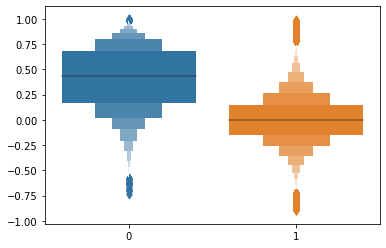

In [5]:
import seaborn as sns
sns.boxenplot(data=[pQTL_df_validated_cocomplex['pearson'].to_numpy(),pQTL_df_validated_non_complex['pearson'].to_numpy()])

In [23]:
## build a graph!!
pQTL_df_validated_cocomplex

,protein_1,protein_2,euclidean,pearson,binary_interaction,cocomplex
3837,O60762,Q9P2X0,2.094235,0.794469,1,1
13124,P48506,P48507,8.572548,-0.094519,0,1
29244,Q9Y6D9,Q13257,2.948131,0.409122,1,1
68473,P54819,Q13158,3.616486,0.196743,0,1
78527,O60341,P51531,5.399765,0.320704,0,1
...,...,...,...,...,...,...
18796377,P62987,P61513,1.559279,0.344924,1,1
18796389,P62987,P30050,0.798080,0.802118,1,1
18796406,P62987,P62750,0.893168,0.853275,1,1
18796433,P62987,P62906,0.783644,0.854695,1,1


In [72]:
all_complexes_id_to_subunits = read_json_from(f"{PATH_ROOT}/data_sources/Corum/all_complexes_id_to_subunits.json")

In [110]:
protein_to_included_complex_id_path = f"{PATH_ROOT}/data_sources/Corum/protein_to_included_complex_id.json"
protein_to_included_complex_id_json = read_json_from(protein_to_included_complex_id_path)

In [145]:
# complex_sizes_dist = [len(all_complex_id_to_subunits[com]) for com in all_complex_id_to_subunits if len(all_complex_id_to_subunits[com]) <= 20]

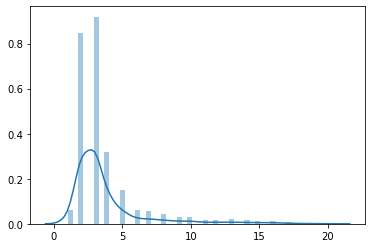

In [146]:
sns.distplot(complex_sizes_dist)

In [28]:
from validation import is_hit,all_complex_id_to_subunits
small_complexes_row_index = []
mid_complexes_row_index = []
for idx,row in pQTL_df_validated_cocomplex.iterrows():
    complex_hit = is_hit([row['protein_1'],row['protein_2']],return_complexes=True)
    for com in complex_hit:
        try:
            if len(all_complex_id_to_subunits[str(com)]) <= 5:
                small_complexes_row_index.append(idx)
                break
            if len(all_complex_id_to_subunits[str(com)]) > 5 and  len(all_complex_id_to_subunits[str(com)]) <= 20:
                mid_complexes_row_index.append(idx)
                break
        except KeyError:
            pass
print(len(small_complexes_row_index))
print(len(mid_complexes_row_index))

NameError: name 'pQTL_df_validated_cocomplex' is not defined

In [29]:
small_complexes_df = pQTL_df_validated_cocomplex.loc[small_complexes_row_index,:]
mid_complexes_df = pQTL_df_validated_cocomplex.loc[mid_complexes_row_index,:]
big_complex_pairs = pQTL_df_validated_cocomplex.loc[pQTL_df_validated_cocomplex.index.difference(small_complexes_row_index),:]
big_complex_pairs = non_small_complex_pairs.loc[non_small_complex_pairs.index.difference(mid_complexes_row_index),:]

NameError: name 'pQTL_df_validated_cocomplex' is not defined

In [ ]:
sns.boxenplot(data=[pQTL_df_validated_cocomplex['pearson'].to_numpy(),pQTL_df_validated_non_complex['pearson'].to_numpy()]

In [ ]:
small_complexes_df = pQTL_df_validated_cocomplex.loc[small_complexes_row_index,:]
non_small_complex_pairs = pQTL_df_validated_cocomplex.loc[pQTL_df_validated_cocomplex.index.difference(small_complexes_row_index),:]

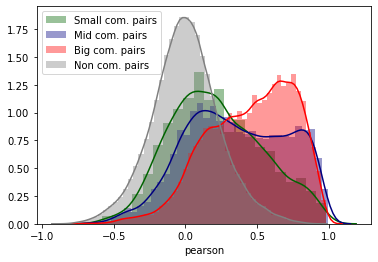

In [169]:
from matplotlib import pyplot as plt
non_complex_pairs_sampled = pQTL_df_validated_non_complex['pearson'].sample(n=100000)
sns.distplot( small_complexes_df['pearson'] , color="darkgreen", label="Small com. pairs",norm_hist=True)
sns.distplot( mid_complexes_df['pearson'] , color="navy", label="Mid com. pairs",norm_hist=True)
sns.distplot( big_complex_pairs['pearson'] , color="red", label="Big com. pairs",norm_hist=True)
sns.distplot( non_complex_pairs_sampled , color="gray", label="Non com. pairs",norm_hist=True)
plt.legend(loc='upper left')

In [172]:
print(small_complexes_df['pearson'].describe())
print(mid_complexes_df['pearson'].describe())
print(big_complex_pairs['pearson'].describe())
print(non_complex_pairs_sampled.describe())

count    2114.000000
mean        0.218226
std         0.320641
min        -0.583247
25%        -0.018411
50%         0.190783
75%         0.441180
max         0.983616
Name: pearson, dtype: float64
count    14338.000000
mean         0.356644
std          0.348615
min         -0.701875
25%          0.087203
50%          0.342368
75%          0.652876
max          0.997545
Name: pearson, dtype: float64
count    28804.000000
mean         0.454496
std          0.298164
min         -0.732151
25%          0.234544
50%          0.491551
75%          0.698167
max          0.978151
Name: pearson, dtype: float64
count    100000.000000
mean          0.002601
std           0.236997
min          -0.860863
25%          -0.146618
50%          -0.000860
75%           0.147436
max           0.917659
Name: pearson, dtype: float64


In [ ]:
pQTL_rna_seq_df = pd.read_csv(f'{PATH_ROOT}/data_sources/pQTL/pQTL_rna_seq_validated.csv')
pQTL_rna_seq_df

In [181]:
pQTL_rna_seq_df_validated_cocomplex = pQTL_rna_seq_df[pQTL_rna_seq_df['cocomplex'] == 1]
pQTL_rna_seq_df_validated_non_complex = pQTL_rna_seq_df[pQTL_rna_seq_df['cocomplex'] == 0]

In [177]:
pQTL_rna_seq_small_complexes_row_index = []
pQTL_rna_seq_mid_complexes_row_index = []
for idx,row in pQTL_rna_seq_df_validated_cocomplex.iterrows():
    complex_hit = is_hit([row['protein_1'],row['protein_2']],return_complexes=True)
    for com in complex_hit:
        try:
            if len(all_complex_id_to_subunits[str(com)]) <= 5:
                pQTL_rna_seq_small_complexes_row_index.append(idx)
                break
            if len(all_complex_id_to_subunits[str(com)]) > 5 and  len(all_complex_id_to_subunits[str(com)]) <= 20:
                pQTL_rna_seq_mid_complexes_row_index.append(idx)
                break
        except KeyError:
            pass
print(len(pQTL_rna_seq_small_complexes_row_index))
print(len(pQTL_rna_seq_mid_complexes_row_index))

2094
14116


In [180]:
pQTL_rna_seq_small_complexes_df = pQTL_rna_seq_df_validated_cocomplex.loc[pQTL_rna_seq_small_complexes_row_index,:]
pQTL_rna_seq_mid_complexes_df = pQTL_rna_seq_df_validated_cocomplex.loc[pQTL_rna_seq_mid_complexes_row_index,:]
pQTL_rna_seq_big_complex_pairs = pQTL_rna_seq_df_validated_cocomplex.loc[pQTL_rna_seq_df_validated_cocomplex.index.difference(pQTL_rna_seq_small_complexes_row_index),:]
pQTL_rna_seq_big_complex_pairs = pQTL_rna_seq_big_complex_pairs.loc[pQTL_rna_seq_big_complex_pairs.index.difference(pQTL_rna_seq_mid_complexes_row_index),:]

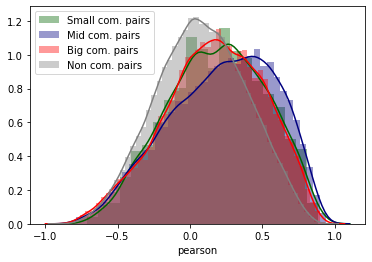

In [182]:
pQTL_rna_seq_non_complex_pairs_sampled = pQTL_rna_seq_df_validated_non_complex['pearson'].sample(n=100000)
sns.distplot( pQTL_rna_seq_small_complexes_df['pearson'] , color="darkgreen", label="Small com. pairs",norm_hist=True)
sns.distplot( pQTL_rna_seq_mid_complexes_df['pearson'] , color="navy", label="Mid com. pairs",norm_hist=True)
sns.distplot( pQTL_rna_seq_big_complex_pairs['pearson'] , color="red", label="Big com. pairs",norm_hist=True)
sns.distplot( pQTL_rna_seq_non_complex_pairs_sampled , color="gray", label="Non com. pairs",norm_hist=True)
plt.legend(loc='upper left')

In [2]:
from data import proteomeHD_df
# Drops rows that are not quantified in at least 1/3 of the experiments
proteomeHD_dropped_df = proteomeHD_df.iloc[proteomeHD_df.isnull().sum(axis=1).to_numpy() <= (294-95),:]
proteomeHD_dropped_df_ids = proteomeHD_dropped_df['Simplified_protein_ID'].to_numpy()
proteomeHD_dropped_df.index = proteomeHD_dropped_df_ids
proteomeHD_dropped_df_feature_df = proteomeHD_dropped_df.iloc[:,4:].T

In [200]:
proteomeHD_dropped_df_feature_df

,A0AV96,A0AVT1,A0FGR8,A0MZ66,A1A4S6,A1L0T0,A2RRP1,A2RUS2,A3KMH1,A3KN83,...,Q9Y6R4,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
RatioHL_GK1_Chromatin_AL,-0.274172,-0.493533,-0.997325,NaN,NaN,-0.958238,-0.199059,NaN,NaN,0.262627,...,NaN,-0.163913,NaN,NaN,-0.004439,NaN,0.082520,0.001429,NaN,-0.345849
RatioHL_GK1_Chromatin_CPT,NaN,0.660840,NaN,-0.787445,NaN,NaN,NaN,NaN,NaN,-0.031625,...,0.003922,0.180509,NaN,NaN,NaN,-0.147481,NaN,-0.639854,NaN,NaN
RatioHL_GK1_Chromatin_CR,-0.525950,-0.229160,NaN,0.525284,NaN,-0.648084,-0.039659,NaN,NaN,0.086525,...,0.376688,-0.355026,-0.225692,NaN,0.028639,NaN,0.060632,0.206372,NaN,0.063052
RatioHL_GK1_Chromatin_HepHek,NaN,1.525756,1.019208,0.287327,NaN,1.344700,1.473365,NaN,1.494107,0.242251,...,-0.739485,-1.048920,0.628207,NaN,-1.606742,NaN,0.706753,-0.021809,NaN,2.069349
RatioHL_GK1_Chromatin_hiIR,NaN,0.322934,NaN,0.692461,-4.272766,-0.040884,NaN,NaN,NaN,0.220707,...,NaN,-0.246073,NaN,-0.910426,-0.026064,NaN,0.643019,-0.252442,NaN,-0.799474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RatioHL_PX441_F1,NaN,0.368652,-0.378592,1.068698,NaN,-0.026494,0.052420,0.293042,NaN,NaN,...,NaN,NaN,NaN,0.113682,0.743857,NaN,NaN,NaN,NaN,0.386488
RatioHL_PX441_F2,NaN,-0.105655,-0.057059,NaN,NaN,0.241705,0.678400,0.313498,NaN,NaN,...,NaN,0.322093,NaN,-0.179393,0.343972,-2.094520,NaN,NaN,NaN,1.154617
RatioHL_PX441_F3,NaN,-0.233525,0.123395,-1.467311,NaN,0.906517,-0.027313,1.121705,NaN,-0.077991,...,NaN,-1.439720,0.249016,-0.678301,-0.329792,-2.201748,NaN,-0.384260,NaN,0.150796
RatioHL_PX441_F4,NaN,-0.447211,-0.336181,-2.497005,NaN,-1.331133,-0.345137,NaN,NaN,1.282676,...,NaN,0.372216,-0.542342,-0.242436,-0.521744,-1.046192,NaN,NaN,NaN,-0.354063


In [3]:
proteomeHD_dropped_df_feature_df_corr = proteomeHD_dropped_df_feature_df.corr()

In [4]:
proteomeHD_dropped_df_feature_df_corr

,A0AV96,A0AVT1,A0FGR8,A0MZ66,A1A4S6,A1L0T0,A2RRP1,A2RUS2,A3KMH1,A3KN83,...,Q9Y6R4,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
A0AV96,1.000000,-0.431411,-0.094415,0.455848,0.071829,0.384105,0.044797,-0.025830,0.036665,-0.214021,...,-0.220737,0.205795,0.278254,0.010129,0.006238,0.425007,0.449022,0.304477,-0.612468,-0.000718
A0AVT1,-0.431411,1.000000,-0.159706,-0.091524,0.240889,-0.131397,-0.124255,-0.134933,-0.017076,-0.391442,...,0.019252,-0.336302,-0.057930,-0.140297,-0.505185,-0.084101,-0.509618,-0.602308,0.321049,0.334175
A0FGR8,-0.094415,-0.159706,1.000000,0.138347,0.322340,0.361987,0.319078,0.607401,-0.270201,0.244635,...,-0.070447,-0.004480,-0.136747,0.487370,0.255446,0.222310,-0.152601,0.041395,-0.088946,-0.294995
A0MZ66,0.455848,-0.091524,0.138347,1.000000,-0.289084,0.287946,0.252261,0.002012,0.078278,0.009210,...,-0.006613,-0.059126,0.368434,-0.031533,0.143856,-0.362575,0.367958,0.160309,-0.105514,0.273601
A1A4S6,0.071829,0.240889,0.322340,-0.289084,1.000000,-0.011932,0.028757,0.497475,0.286646,-0.345136,...,0.074987,0.008556,-0.099811,-0.025742,-0.063591,0.237251,-0.239788,-0.140437,0.035715,-0.011225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X5,0.425007,-0.084101,0.222310,-0.362575,0.237251,0.046153,0.029913,0.341321,-0.136022,-0.006928,...,-0.011801,-0.079180,0.024860,0.384848,-0.334204,1.000000,-0.235221,-0.231404,-0.328365,-0.507690
Q9Y6X8,0.449022,-0.509618,-0.152601,0.367958,-0.239788,-0.026363,-0.127298,0.006246,-0.177634,0.341963,...,0.006577,0.304447,0.273708,-0.216538,0.168282,-0.235221,1.000000,0.669537,-0.441846,-0.215904
Q9Y6X9,0.304477,-0.602308,0.041395,0.160309,-0.140437,0.115064,0.056445,-0.260511,-0.139058,0.403243,...,0.018868,0.302319,0.070261,0.115117,0.498486,-0.231404,0.669537,1.000000,-0.008747,-0.062775
Q9Y6Y0,-0.612468,0.321049,-0.088946,-0.105514,0.035715,-0.237479,0.138608,-0.134134,0.020129,0.393377,...,0.396069,-0.157808,-0.271083,0.373383,0.154335,-0.328365,-0.441846,-0.008747,1.000000,0.335174


In [5]:
tup_list = []
proteomeHD_dropped_df_feature_df_corr_numpy = proteomeHD_dropped_df_feature_df_corr.to_numpy()
for i in range(len(proteomeHD_dropped_df_ids)):
    if i % 1000 == 1:
        print(i)
    for j in range(len(proteomeHD_dropped_df_ids)):
        if i!= j:
            tup_list.append((proteomeHD_dropped_df_ids[i],proteomeHD_dropped_df_ids[j],proteomeHD_dropped_df_feature_df_corr_numpy[i,j]))
cols = ['protein_1','protein_2','pearson']
proHD_reduced_df = pd.DataFrame(data=tup_list,columns=cols)
proHD_reduced_df

1
1001
2001
3001
4001
5001


,protein_1,protein_2,pearson
0,A0AV96,A0AVT1,-0.431411
1,A0AV96,A0FGR8,-0.094415
2,A0AV96,A0MZ66,0.455848
3,A0AV96,A1A4S6,0.071829
4,A0AV96,A1L0T0,0.384105
...,...,...,...
25125151,Q9Y6Y8,Q9Y6X3,-0.007414
25125152,Q9Y6Y8,Q9Y6X5,-0.507690
25125153,Q9Y6Y8,Q9Y6X8,-0.215904
25125154,Q9Y6Y8,Q9Y6X9,-0.062775


In [7]:
from validation import validate_relations_in_df
proHD_reduced_df_validated = validate_relations_in_df(proHD_reduced_df,timed=True)

Current Index: 1, ETA: 185642131.12419486
Current Index: 10001, ETA: 25233.791784173
Current Index: 20001, ETA: 15115.144628687065
Current Index: 30001, ETA: 11933.658412874613
Current Index: 40001, ETA: 10155.584600777487
Current Index: 50001, ETA: 8912.759064679785
Current Index: 60001, ETA: 7995.270463602915
Current Index: 70001, ETA: 7414.826661242538
Current Index: 80001, ETA: 6993.816719116731
Current Index: 90001, ETA: 6521.905058186483
Current Index: 100001, ETA: 6207.520477398435
Current Index: 110001, ETA: 5906.292938105224
Current Index: 120001, ETA: 5661.468867310105
Current Index: 130001, ETA: 5566.56238252135
Current Index: 140001, ETA: 5447.506977555137
Current Index: 150001, ETA: 5249.966745077039
Current Index: 160001, ETA: 5111.100076451853
Current Index: 170001, ETA: 4962.011334730297
Current Index: 180001, ETA: 4872.20416243535
Current Index: 190001, ETA: 4898.120367122118
Current Index: 200001, ETA: 4788.187275380699
Current Index: 210001, ETA: 4816.047271657676
Cu

Current Index: 1770001, ETA: 3415.5891740175457
Current Index: 1780001, ETA: 3409.5327174702365
Current Index: 1790001, ETA: 3401.756283941452
Current Index: 1800001, ETA: 3395.937775631049
Current Index: 1810001, ETA: 3390.4076513728105
Current Index: 1820001, ETA: 3385.821673283475
Current Index: 1830001, ETA: 3380.667471197073
Current Index: 1840001, ETA: 3378.6036453825195
Current Index: 1850001, ETA: 3378.8472518404647
Current Index: 1860001, ETA: 3372.2792355523816
Current Index: 1870001, ETA: 3368.5445324808006
Current Index: 1880001, ETA: 3363.269041152239
Current Index: 1890001, ETA: 3357.766888608576
Current Index: 1900001, ETA: 3353.0558204835897
Current Index: 1910001, ETA: 3346.486316034421
Current Index: 1920001, ETA: 3341.1469628751624
Current Index: 1930001, ETA: 3335.022537302196
Current Index: 1940001, ETA: 3332.613777127814
Current Index: 1950001, ETA: 3329.655174812459
Current Index: 1960001, ETA: 3327.67801291458
Current Index: 1970001, ETA: 3328.0642086700136
Curr

Current Index: 3500001, ETA: 3004.006849613634
Current Index: 3510001, ETA: 3000.5371079471247
Current Index: 3520001, ETA: 2998.583274927811
Current Index: 3530001, ETA: 2997.5599789149655
Current Index: 3540001, ETA: 2995.7753523108145
Current Index: 3550001, ETA: 2994.0081175185837
Current Index: 3560001, ETA: 3001.7929171200094
Current Index: 3570001, ETA: 3002.5806552463823
Current Index: 3580001, ETA: 3001.3886038897062
Current Index: 3590001, ETA: 3003.068385953297
Current Index: 3600001, ETA: 3001.581430894691
Current Index: 3610001, ETA: 3001.5318053921915
Current Index: 3620001, ETA: 2999.981708191848
Current Index: 3630001, ETA: 2998.2612343998867
Current Index: 3640001, ETA: 2996.4656889300795
Current Index: 3650001, ETA: 2995.043711599499
Current Index: 3660001, ETA: 2993.216867443432
Current Index: 3670001, ETA: 2992.6273878501033
Current Index: 3680001, ETA: 2996.070001061543
Current Index: 3690001, ETA: 2994.7116339894574
Current Index: 3700001, ETA: 2993.317412251484
C

Current Index: 5230001, ETA: 2850.177277838125
Current Index: 5240001, ETA: 2848.5476536138835
Current Index: 5250001, ETA: 2847.748592909998
Current Index: 5260001, ETA: 2846.2633965410078
Current Index: 5270001, ETA: 2845.9059239908684
Current Index: 5280001, ETA: 2846.2819826663062
Current Index: 5290001, ETA: 2844.606978003693
Current Index: 5300001, ETA: 2843.033858731834
Current Index: 5310001, ETA: 2841.531432905851
Current Index: 5320001, ETA: 2839.9631533919096
Current Index: 5330001, ETA: 2838.3401315471037
Current Index: 5340001, ETA: 2836.858586567131
Current Index: 5350001, ETA: 2835.948383583675
Current Index: 5360001, ETA: 2835.539069071924
Current Index: 5370001, ETA: 2837.211973594259
Current Index: 5380001, ETA: 2836.68597334843
Current Index: 5390001, ETA: 2835.799838202321
Current Index: 5400001, ETA: 2834.4730191742105
Current Index: 5410001, ETA: 2833.1856703017866
Current Index: 5420001, ETA: 2833.062012037915
Current Index: 5430001, ETA: 2831.647035780693
Curren

Current Index: 6960001, ETA: 2586.2214038310467
Current Index: 6970001, ETA: 2584.4060170359626
Current Index: 6980001, ETA: 2582.814896549932
Current Index: 6990001, ETA: 2581.1620914089085
Current Index: 7000001, ETA: 2579.492045739162
Current Index: 7010001, ETA: 2577.8280706450446
Current Index: 7020001, ETA: 2576.304453183329
Current Index: 7030001, ETA: 2574.7709916616805
Current Index: 7040001, ETA: 2573.137603717808
Current Index: 7050001, ETA: 2571.594889147482
Current Index: 7060001, ETA: 2569.914407624538
Current Index: 7070001, ETA: 2568.326898497122
Current Index: 7080001, ETA: 2566.6559064786616
Current Index: 7090001, ETA: 2565.535120080711
Current Index: 7100001, ETA: 2563.997126834865
Current Index: 7110001, ETA: 2565.1412502432663
Current Index: 7120001, ETA: 2563.9042142540716
Current Index: 7130001, ETA: 2562.263221712613
Current Index: 7140001, ETA: 2561.0597032283254
Current Index: 7150001, ETA: 2559.535237169645
Current Index: 7160001, ETA: 2558.1144884803266
Cur

Current Index: 8690001, ETA: 2321.946192188988
Current Index: 8700001, ETA: 2320.4828151859124
Current Index: 8710001, ETA: 2318.991392897453
Current Index: 8720001, ETA: 2317.511448660734
Current Index: 8730001, ETA: 2316.1144265034986
Current Index: 8740001, ETA: 2314.5842294858357
Current Index: 8750001, ETA: 2313.21571213384
Current Index: 8760001, ETA: 2311.714010464959
Current Index: 8770001, ETA: 2310.4663097051553
Current Index: 8780001, ETA: 2308.957458381964
Current Index: 8790001, ETA: 2307.48601658107
Current Index: 8800001, ETA: 2306.1020492612734
Current Index: 8810001, ETA: 2304.6438406145617
Current Index: 8820001, ETA: 2303.167357992856
Current Index: 8830001, ETA: 2301.587783780358
Current Index: 8840001, ETA: 2300.1340342582366
Current Index: 8850001, ETA: 2298.6582479365075
Current Index: 8860001, ETA: 2297.1589821027833
Current Index: 8870001, ETA: 2295.7167519687123
Current Index: 8880001, ETA: 2294.250779942254
Current Index: 8890001, ETA: 2292.7686307878243
Curr

Current Index: 10410001, ETA: 2076.9174957969585
Current Index: 10420001, ETA: 2075.702769400825
Current Index: 10430001, ETA: 2074.619801330705
Current Index: 10440001, ETA: 2072.8661637085693
Current Index: 10450001, ETA: 2070.9594948080944
Current Index: 10460001, ETA: 2069.1624548250797
Current Index: 10470001, ETA: 2067.6802276581693
Current Index: 10480001, ETA: 2066.4567857323505
Current Index: 10490001, ETA: 2064.9829162968695
Current Index: 10500001, ETA: 2063.4967626161547
Current Index: 10510001, ETA: 2062.3738045346636
Current Index: 10520001, ETA: 2061.009780968304
Current Index: 10530001, ETA: 2059.638646980853
Current Index: 10540001, ETA: 2058.52050919031
Current Index: 10550001, ETA: 2056.9289798298
Current Index: 10560001, ETA: 2055.5284540227426
Current Index: 10570001, ETA: 2054.162225704406
Current Index: 10580001, ETA: 2052.789011450118
Current Index: 10590001, ETA: 2051.8288184956555
Current Index: 10600001, ETA: 2050.5095001272234
Current Index: 10610001, ETA: 2

Current Index: 12100001, ETA: 1832.9606805927506
Current Index: 12110001, ETA: 1831.451113368395
Current Index: 12120001, ETA: 1830.0557025099147
Current Index: 12130001, ETA: 1828.5969222174115
Current Index: 12140001, ETA: 1827.121986757383
Current Index: 12150001, ETA: 1825.659354361954
Current Index: 12160001, ETA: 1824.2226745082517
Current Index: 12170001, ETA: 1822.9165032993608
Current Index: 12180001, ETA: 1821.5071903741325
Current Index: 12190001, ETA: 1820.0851020477894
Current Index: 12200001, ETA: 1818.633433928866
Current Index: 12210001, ETA: 1817.1417501464211
Current Index: 12220001, ETA: 1815.6555503300403
Current Index: 12230001, ETA: 1814.241399166601
Current Index: 12240001, ETA: 1812.8060660211456
Current Index: 12250001, ETA: 1811.3845669680481
Current Index: 12260001, ETA: 1809.9001866394199
Current Index: 12270001, ETA: 1808.4422163763522
Current Index: 12280001, ETA: 1806.9958706914408
Current Index: 12290001, ETA: 1805.5831473832386
Current Index: 12300001, 

Current Index: 13780001, ETA: 1588.6162654791365
Current Index: 13790001, ETA: 1587.1344147660825
Current Index: 13800001, ETA: 1585.6700784050493
Current Index: 13810001, ETA: 1584.1707046082101
Current Index: 13820001, ETA: 1582.7026820393155
Current Index: 13830001, ETA: 1581.193269839964
Current Index: 13840001, ETA: 1579.8522037207067
Current Index: 13850001, ETA: 1578.3603051044774
Current Index: 13860001, ETA: 1576.7508949803143
Current Index: 13870001, ETA: 1575.1315744013746
Current Index: 13880001, ETA: 1573.4708444338391
Current Index: 13890001, ETA: 1571.7672722052062
Current Index: 13900001, ETA: 1570.0581864303374
Current Index: 13910001, ETA: 1568.3928893602283
Current Index: 13920001, ETA: 1566.895025264278
Current Index: 13930001, ETA: 1565.453763294434
Current Index: 13940001, ETA: 1563.991776622247
Current Index: 13950001, ETA: 1562.5116016692784
Current Index: 13960001, ETA: 1561.0420280065066
Current Index: 13970001, ETA: 1559.991166287215
Current Index: 13980001, 

Current Index: 15460001, ETA: 1335.9516610662827
Current Index: 15470001, ETA: 1334.5817639878974
Current Index: 15480001, ETA: 1333.1868788039387
Current Index: 15490001, ETA: 1331.790210376828
Current Index: 15500001, ETA: 1330.3941922006536
Current Index: 15510001, ETA: 1329.054011837033
Current Index: 15520001, ETA: 1327.6282905262233
Current Index: 15530001, ETA: 1326.2756165442247
Current Index: 15540001, ETA: 1325.0387791841604
Current Index: 15550001, ETA: 1324.1955655827162
Current Index: 15560001, ETA: 1322.9454302553168
Current Index: 15570001, ETA: 1321.6997517210912
Current Index: 15580001, ETA: 1320.3580484982913
Current Index: 15590001, ETA: 1319.0959239306467
Current Index: 15600001, ETA: 1317.7586488487043
Current Index: 15610001, ETA: 1316.3718761234747
Current Index: 15620001, ETA: 1315.0045915177466
Current Index: 15630001, ETA: 1313.636077459996
Current Index: 15640001, ETA: 1312.3135359484788
Current Index: 15650001, ETA: 1310.9569111612764
Current Index: 15660001

Current Index: 17150001, ETA: 1110.7244381617083
Current Index: 17160001, ETA: 1109.2399271398574
Current Index: 17170001, ETA: 1107.7094221220373
Current Index: 17180001, ETA: 1106.2048419650123
Current Index: 17190001, ETA: 1104.7829867200528
Current Index: 17200001, ETA: 1103.471236338199
Current Index: 17210001, ETA: 1102.2074834742061
Current Index: 17220001, ETA: 1100.8679578601857
Current Index: 17230001, ETA: 1099.5685010016184
Current Index: 17240001, ETA: 1098.245735903509
Current Index: 17250001, ETA: 1096.9836490545717
Current Index: 17260001, ETA: 1095.7114408112886
Current Index: 17270001, ETA: 1094.3723924236706
Current Index: 17280001, ETA: 1092.997274886117
Current Index: 17290001, ETA: 1091.6679049645209
Current Index: 17300001, ETA: 1090.2903095413483
Current Index: 17310001, ETA: 1088.9799080514915
Current Index: 17320001, ETA: 1087.7547543179594
Current Index: 17330001, ETA: 1086.3960639337213
Current Index: 17340001, ETA: 1085.0207489509285
Current Index: 17350001

Current Index: 18850001, ETA: 865.9295177913202
Current Index: 18860001, ETA: 864.4768692349726
Current Index: 18870001, ETA: 863.0006369330595
Current Index: 18880001, ETA: 861.5010224169474
Current Index: 18890001, ETA: 860.035908483894
Current Index: 18900001, ETA: 858.5533698498864
Current Index: 18910001, ETA: 857.088681410094
Current Index: 18920001, ETA: 855.6761885514256
Current Index: 18930001, ETA: 854.2285064560862
Current Index: 18940001, ETA: 852.7507268312095
Current Index: 18950001, ETA: 851.2929393586402
Current Index: 18960001, ETA: 849.7990644510443
Current Index: 18970001, ETA: 848.3027622270091
Current Index: 18980001, ETA: 846.8740434653857
Current Index: 18990001, ETA: 845.3983299556581
Current Index: 19000001, ETA: 843.9606126827496
Current Index: 19010001, ETA: 842.5255263956229
Current Index: 19020001, ETA: 841.0499465014448
Current Index: 19030001, ETA: 839.5770060425187
Current Index: 19040001, ETA: 838.1038538595257
Current Index: 19050001, ETA: 836.60720512

Current Index: 20570001, ETA: 617.3531833632218
Current Index: 20580001, ETA: 615.9652651364057
Current Index: 20590001, ETA: 614.5421735344709
Current Index: 20600001, ETA: 613.1194305884105
Current Index: 20610001, ETA: 611.697944732496
Current Index: 20620001, ETA: 610.2763730193219
Current Index: 20630001, ETA: 608.8481818245582
Current Index: 20640001, ETA: 607.451633750542
Current Index: 20650001, ETA: 606.0181027277877
Current Index: 20660001, ETA: 604.5882352479603
Current Index: 20670001, ETA: 603.1863619755229
Current Index: 20680001, ETA: 601.765196131865
Current Index: 20690001, ETA: 600.3422567626417
Current Index: 20700001, ETA: 598.9179889431758
Current Index: 20710001, ETA: 597.4919695501161
Current Index: 20720001, ETA: 596.0710290249633
Current Index: 20730001, ETA: 594.6394263912248
Current Index: 20740001, ETA: 593.2122894395549
Current Index: 20750001, ETA: 591.7920923448017
Current Index: 20760001, ETA: 590.406721173915
Current Index: 20770001, ETA: 589.0110785885

Current Index: 22280001, ETA: 380.52712527894806
Current Index: 22290001, ETA: 379.1481504347936
Current Index: 22300001, ETA: 377.7828168794795
Current Index: 22310001, ETA: 376.40078427029624
Current Index: 22320001, ETA: 375.01785323400156
Current Index: 22330001, ETA: 373.63785456759706
Current Index: 22340001, ETA: 372.2556488543731
Current Index: 22350001, ETA: 370.87505213095517
Current Index: 22360001, ETA: 369.4990163341195
Current Index: 22370001, ETA: 368.11677444376426
Current Index: 22380001, ETA: 366.74607060910654
Current Index: 22390001, ETA: 365.3653815118721
Current Index: 22400001, ETA: 363.98628512733563
Current Index: 22410001, ETA: 362.60439217791776
Current Index: 22420001, ETA: 361.2324121699807
Current Index: 22430001, ETA: 359.86193611436147
Current Index: 22440001, ETA: 358.48361396916505
Current Index: 22450001, ETA: 357.1032644045395
Current Index: 22460001, ETA: 355.7268618447004
Current Index: 22470001, ETA: 354.37359413560614
Current Index: 22480001, ETA

Current Index: 23970001, ETA: 156.04291421399031
Current Index: 23980001, ETA: 154.68162397367587
Current Index: 23990001, ETA: 153.3114542177344
Current Index: 24000001, ETA: 151.9413484947637
Current Index: 24010001, ETA: 150.57425237527306
Current Index: 24020001, ETA: 149.2049386213381
Current Index: 24030001, ETA: 147.8355297559732
Current Index: 24040001, ETA: 146.4669412860223
Current Index: 24050001, ETA: 145.09956174975613
Current Index: 24060001, ETA: 143.73194958230894
Current Index: 24070001, ETA: 142.36438455842585
Current Index: 24080001, ETA: 140.99678602530614
Current Index: 24090001, ETA: 139.63032948615884
Current Index: 24100001, ETA: 138.2641394565078
Current Index: 24110001, ETA: 136.89838333033805
Current Index: 24120001, ETA: 135.53688366349536
Current Index: 24130001, ETA: 134.17059115482482
Current Index: 24140001, ETA: 132.80467251320866
Current Index: 24150001, ETA: 131.4392095388843
Current Index: 24160001, ETA: 130.07347591661292
Current Index: 24170001, ET

In [8]:
proHD_reduced_df_validated.to_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_reduced_pairs_validated.csv",index=False)

In [9]:
proHD_reduced_df_validated

,protein_1,protein_2,pearson,binary_interaction,cocomplex
0,A0AV96,A0AVT1,-0.431411,0,0
1,A0AV96,A0FGR8,-0.094415,0,0
2,A0AV96,A0MZ66,0.455848,0,0
3,A0AV96,A1A4S6,0.071829,0,0
4,A0AV96,A1L0T0,0.384105,0,0
...,...,...,...,...,...
25125151,Q9Y6Y8,Q9Y6X3,-0.007414,0,0
25125152,Q9Y6Y8,Q9Y6X5,-0.507690,0,0
25125153,Q9Y6Y8,Q9Y6X8,-0.215904,0,0
25125154,Q9Y6Y8,Q9Y6X9,-0.062775,0,0


In [11]:
proHD_reduced_cocomplex_pairs = proHD_reduced_df_validated[proHD_reduced_df_validated['cocomplex'] == 1]

In [12]:
proHD_reduced_cocomplex_pairs

,protein_1,protein_2,pearson,binary_interaction,cocomplex
13885,A0FGR8,Q9BSJ8,0.358657,0,1
21302,A1A4S6,P35221,-0.279972,0,1
60523,A5YKK6,O75175,0.422648,1,1
61247,A5YKK6,P26196,0.388516,1,1
63535,A5YKK6,Q92600,0.525034,1,1
...,...,...,...,...,...
25094865,Q9Y6W5,Q9Y2A7,0.518359,1,1
25120699,Q9Y6Y8,O95487,0.411172,1,1
25122589,Q9Y6Y8,Q15436,0.173021,1,1
25124375,Q9Y6Y8,Q9HCU5,0.176553,0,1


In [15]:
seen_pairs = set()
keep_idx = []
for idx,row in proHD_reduced_cocomplex_pairs.iterrows():
    one_way = row['protein_1']+";"+row['protein_2']
    two_way= row['protein_2']+";"+row['protein_1']
    if not (one_way in seen_pairs or two_way in seen_pairs):
        keep_idx.append(idx)
        seen_pairs.add(one_way)
        seen_pairs.add(two_way)
print(len(keep_idx))

28494


In [17]:
proHD_reduced_cocomplex_pairs_dedup = proHD_reduced_cocomplex_pairs.loc[keep_idx]
proHD_reduced_cocomplex_pairs_dedup

,protein_1,protein_2,pearson,binary_interaction,cocomplex
13885,A0FGR8,Q9BSJ8,0.358657,0,1
21302,A1A4S6,P35221,-0.279972,0,1
60523,A5YKK6,O75175,0.422648,1,1
61247,A5YKK6,P26196,0.388516,1,1
63535,A5YKK6,Q92600,0.525034,1,1
...,...,...,...,...,...
24784272,Q9Y5Q8,Q9Y5Q9,0.760987,1,1
24804351,Q9Y5S9,Q9Y6A4,0.091282,0,1
24959759,Q9Y6B6,Q9Y6Y8,0.154499,1,1
25004851,Q9Y6G9,Q9Y6K9,0.031508,0,1


In [18]:
proHD_reduced_cocomplex_pairs_dedup.to_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_reduced_cocomplex_pairs_validated.csv",index=False)

In [ ]:
proHD_reduced_cocomplex_pairs_dedup

In [21]:
from validation import is_hit,all_complex_id_to_subunits
proteomeHD_reduced_small_complexes_row_index = []
proteomeHD_reduced_mid_complexes_row_index = []
for idx,row in proHD_reduced_cocomplex_pairs_dedup.iterrows():
    complex_hit = is_hit([row['protein_1'],row['protein_2']],return_complexes=True)
    for com in complex_hit:
        try:
            if len(all_complex_id_to_subunits[str(com)]) <= 5:
                proteomeHD_reduced_small_complexes_row_index.append(idx)
                break
            if len(all_complex_id_to_subunits[str(com)]) > 5 and  len(all_complex_id_to_subunits[str(com)]) <= 40:
                proteomeHD_reduced_mid_complexes_row_index.append(idx)
                break
        except KeyError:
            pass
print(len(proteomeHD_reduced_small_complexes_row_index))
print(len(proteomeHD_reduced_mid_complexes_row_index))

1493
9055


In [22]:
proteomeHD_reduced_small_complexes_df = proHD_reduced_cocomplex_pairs_dedup.loc[proteomeHD_reduced_small_complexes_row_index,:]
proteomeHD_reduced_mid_complexes_df = proHD_reduced_cocomplex_pairs_dedup.loc[proteomeHD_reduced_mid_complexes_row_index,:]
proteomeHD_reduced_big_complex_pairs = proHD_reduced_cocomplex_pairs_dedup.loc[proHD_reduced_cocomplex_pairs_dedup.index.difference(proteomeHD_reduced_small_complexes_row_index),:]
proteomeHD_reduced_big_complex_pairs = proHD_reduced_cocomplex_pairs_dedup.loc[proteomeHD_reduced_big_complex_pairs.index.difference(proteomeHD_reduced_mid_complexes_row_index),:]

In [26]:
proHD_reduced_df_validated_non_complex = proHD_reduced_df_validated[proHD_reduced_df_validated['cocomplex'] == 0]

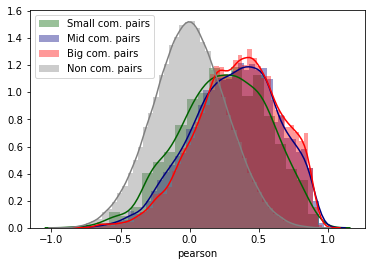

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
proteomeHD_reduced_non_complex_pairs_sampled = proHD_reduced_df_validated_non_complex['pearson'].sample(n=100000)
sns.distplot( proteomeHD_reduced_small_complexes_df['pearson'] , color="darkgreen", label="Small com. pairs",norm_hist=True)
sns.distplot( proteomeHD_reduced_mid_complexes_df['pearson'] , color="navy", label="Mid com. pairs",norm_hist=True)
sns.distplot( proteomeHD_reduced_big_complex_pairs['pearson'] , color="red", label="Big com. pairs",norm_hist=True)
sns.distplot( proteomeHD_reduced_non_complex_pairs_sampled , color="gray", label="Non com. pairs",norm_hist=True)
plt.legend(loc='upper left')